In [4]:
import os
from DNASkittleUtils.DDVUtils import pp
import csv
from collections import defaultdict

# Lizzy's Data

In [5]:
from pandas import read_csv
liz = read_csv("GOenrich_db/lizzy_ash_ks.csv", sep='\t')
liz = liz[liz['Ks'] < 20]  # remove a couple bad values
print(len(liz), "pairs")

20865 pairs


In [3]:
wgd_recent = (liz['Ks'] > 0.16) & (liz['Ks'] < 0.38)
wgd_old = (liz['Ks'] > 0.5) & (liz['Ks'] < 0.8)
recent_duplication = liz['Ks'] < 0.2
unaffected =  ~wgd_old & ~recent_duplication  # ~wgd_recent &
affected = wgd_recent | wgd_old #| recent_duplication
len(liz[unaffected]), len(affected)
pp(len(liz[wgd_recent]) / len(liz))

'35.772825%'

In [4]:
liz.head()

,Group,Gene 1,Gene 2,Ks
0,10,130.1,342640.1,0.3768
1,10,130.1,254110.1,1.5491
2,10,130.1,83020.1,1.6002
3,10,342640.1,254110.1,2.8645
4,10,342640.1,83020.1,0.9481


In [5]:
from itertools import chain
def liz_rows_into_gene_list(liz):
    wgd_genes = set(['FRAEX38873_v2_' + str(x).zfill(11) for x in chain(liz['Gene 1'], liz['Gene 2'])])
    return wgd_genes
wgd_genes = liz_rows_into_gene_list(liz[wgd_recent])
pp(len(wgd_genes))

'13,033'

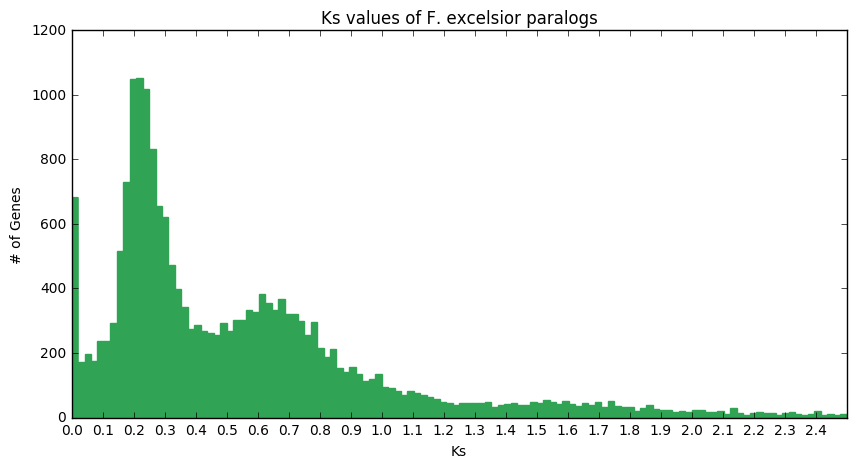

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.xticks(np.arange(0, 2.6, .1))
h = liz[liz['Ks'] < 2.5]['Ks'].hist(bins=120, figsize=(10,5), facecolor='#31a354', edgecolor='#31a354')
h.grid(False)
# h.linewidth(0)
h.set_xlabel('Ks')
h.set_ylabel('# of Genes')
h.set_title('Ks values of F. excelsior paralogs')

In [7]:
ortho_file = r"Ash_Proteome\Results_Jun25\Orthogroups.csv"
orthogroups = {}
excelsior_orthogroups = {}
OG_order = []
with open(ortho_file, newline='' ) as csvfile:
    reader = csv.reader(csvfile, delimiter=' ')
    for nLines, row in enumerate(reader):
        og = row[0].replace(':','')
        orthogroups[og] = {'genes': list(row[1:])}
        if any([name.startswith('FRAEX') for name in orthogroups[og]['genes']]):
            excelsior_orthogroups[og] = orthogroups[og]
        OG_order.append(og)
        
gene2family = {gene: family for (family, row) in excelsior_orthogroups.items() for gene in row['genes']}

In [8]:
# wgd_genes = liz_rows_into_gene_list(liz[(liz['Ks'] > .2) & (liz['Ks'] < .3)])
wgd_by_family = set()
for gene in wgd_genes:
    if gene in gene2family:
        wgd_by_family.add(gene2family[gene])
len(wgd_by_family), pp(len(wgd_by_family) / len(excelsior_orthogroups))

(6105, '27.210733%')

**Conculsion** Functional orthogroups is prefiltered to only have families where members of excelsior are present. This 30% result then means that 30% of the gene families where we could have detected a WGD showed evidence of a WGD. That's very consistent with other numbers I've gotten.  
The 3% discrepancy (30-27) between FunctionsForFamilies is because of the annotation != "NULL" requirement, which is not included here. 

# CAFE tree approximations

In [9]:
from newick import loads
import newick

In [10]:
all_trees = {}
with open(r"CAFE-4.2\data\all_species\reports\WGD_manual_all_species.cafe", 'r') as csvfile:
    lines = csvfile.readlines()[11:]
    for nLines, row in enumerate(lines):
        row = row.split('\t')
        all_trees[int(row[0])] = row[1]
len(all_trees)

16191

In [11]:
ordered_names = loads('((((((((((((FRAX30:2,FRAX32:2)<1>:1,FRAX28:3)<3>:2,FRAX12:5)<5>:4,(FRAX07:8,FRAX29:8)<9>:1)<7>:4,FRAX08:13)<11>:1,(((((FRAX01:2,FRAX16:2)<15>:4,FRAX15:6)<17>:2,FRAX00:8)<19>:2,(FRAX06:9,FRAX23:9)<23>:1)<21>:3,FRAX25:13)<25>:1)<13>:3,FRAX21:17)<27>:2,(((FRAX19:8,FRAX20:8)<31>:2,((FRAX11:5,FRAX27:5)<35>:4,FRAX04:9)<37>:1)<33>:1,(((((FRAX03:1,FRAX09:1)<41>:1,FRAX13:2)<43>:2,(FRAX26:2,FRAX14:2)<47>:2)<45>:3,FRAX05:7)<49>:2,FRAX33:9)<51>:2)<39>:8)<29>:15,FRAX31:34)<53>:2,Oeuropea:36)<55>:1,empty:37)<57>:42,(Slycopersicum:37,Mguttatus:37)<61>:42)<59>')[0]
def create_ordered_nodes(verbose=False):
    ordered_nodes = []
    for node in ordered_names.walk(mode="preorder"):
        if verbose:
            print(node.name, node.length)
        ordered_nodes.append({'name': node.name, 'length':node.length, 'losses': 0, 'gains': 0, 'avg#': 0})
    return ordered_nodes
ordered_nodes = create_ordered_nodes()

In [12]:
def extract_count(name):
    if isinstance(name, newick.Node):
        name = name.name
    return int(name.split('_')[-1])

In [13]:
ordered_nodes[2]

{'avg#': 0, 'gains': 0, 'length': 1.0, 'losses': 0, 'name': '<55>'}

In [14]:
def get_count_at_root(fam_id, ordered_node_index=2):
    newick_str = all_trees[fam_id]
    tree = loads(newick_str)[0]
    for index, node in enumerate(tree.walk(mode="preorder")):
        if index == ordered_node_index:
            count = extract_count(node)
            return count

In [15]:
%%html
<img src="all_species_node_labels_WGD_manual.png">

## Filter Families to Ones with a Duplication at Root < 55 > 

In [31]:
def populate_history_histogram(study_ints):
    ordered_nodes = create_ordered_nodes()
    genes_lost = {node['name']:set() for node in ordered_nodes}
    gene_gains = {node['name']:set() for node in ordered_nodes}
    for fam_id in study_ints:
        if fam_id not in all_trees:
            continue
        newick_str = all_trees[fam_id]
        tree = loads(newick_str)[0]
        for index, node in enumerate(tree.walk(mode="preorder")):
            count = extract_count(node)
            tail = ''
            ordered_nodes[index]['avg#'] += count
            if node.ancestor:
                parent_count = extract_count(node.ancestor.name)
                if count < parent_count:
                    tail = ("loss")
                    ordered_nodes[index]['losses'] += 1 #parent_count - count
                    genes_lost[ordered_nodes[index]['name']].add(fam_id)  # record gene family
                elif count > parent_count:
                    tail = ("gain")
                    ordered_nodes[index]['gains'] += 1 #count - parent_count 
                    gene_gains[ordered_nodes[index]['name']].add(fam_id)
#             print(node.name, count, tail)
    for result in ordered_nodes:  # divide sum by length to get mean
        result['avg#'] /= len(study_ints)
    return ordered_nodes, genes_lost, gene_gains

study_ints = [int(fam[2:]) for fam in excelsior_orthogroups.keys()]
ordered_nodes, genes_lost, gene_gains = populate_history_histogram(study_ints)

In [17]:
len(gene_gains['<55>'])

5634

In [33]:
{key: len(val) for key, val in gene_gains.items()}

{'<11>': 25,
 '<13>': 29,
 '<15>': 24,
 '<17>': 49,
 '<19>': 30,
 '<1>': 36,
 '<21>': 71,
 '<23>': 10,
 '<25>': 2,
 '<27>': 0,
 '<29>': 19,
 '<31>': 31,
 '<33>': 7,
 '<35>': 43,
 '<37>': 39,
 '<39>': 24,
 '<3>': 44,
 '<41>': 17,
 '<43>': 43,
 '<45>': 72,
 '<47>': 22,
 '<49>': 83,
 '<51>': 43,
 '<53>': 0,
 '<55>': 5634,
 '<57>': 0,
 '<59>': 0,
 '<5>': 38,
 '<61>': 30,
 '<7>': 122,
 '<9>': 21,
 'FRAX00': 510,
 'FRAX01': 177,
 'FRAX03': 261,
 'FRAX04': 129,
 'FRAX05': 325,
 'FRAX06': 195,
 'FRAX07': 225,
 'FRAX08': 164,
 'FRAX09': 574,
 'FRAX11': 227,
 'FRAX12': 183,
 'FRAX13': 176,
 'FRAX14': 123,
 'FRAX15': 156,
 'FRAX16': 136,
 'FRAX19': 378,
 'FRAX20': 165,
 'FRAX21': 143,
 'FRAX23': 115,
 'FRAX25': 134,
 'FRAX26': 214,
 'FRAX27': 158,
 'FRAX28': 255,
 'FRAX29': 401,
 'FRAX30': 184,
 'FRAX31': 13,
 'FRAX32': 216,
 'FRAX33': 242,
 'Mguttatus': 484,
 'Oeuropea': 38,
 'Slycopersicum': 629,
 'empty': 0}

In [32]:
{key: len(val) for key, val in genes_lost.items()}

{'<11>': 367,
 '<13>': 457,
 '<15>': 877,
 '<17>': 1263,
 '<19>': 373,
 '<1>': 716,
 '<21>': 788,
 '<23>': 42,
 '<25>': 115,
 '<27>': 278,
 '<29>': 2658,
 '<31>': 582,
 '<33>': 502,
 '<35>': 941,
 '<37>': 260,
 '<39>': 1430,
 '<3>': 467,
 '<41>': 400,
 '<43>': 353,
 '<45>': 405,
 '<47>': 1188,
 '<49>': 382,
 '<51>': 543,
 '<53>': 118,
 '<55>': 0,
 '<57>': 3047,
 '<59>': 0,
 '<5>': 966,
 '<61>': 1422,
 '<7>': 701,
 '<9>': 31,
 'FRAX00': 1333,
 'FRAX01': 995,
 'FRAX03': 1870,
 'FRAX04': 2594,
 'FRAX05': 2280,
 'FRAX06': 2165,
 'FRAX07': 1995,
 'FRAX08': 3515,
 'FRAX09': 797,
 'FRAX11': 897,
 'FRAX12': 2482,
 'FRAX13': 2111,
 'FRAX14': 1793,
 'FRAX15': 2361,
 'FRAX16': 1992,
 'FRAX19': 1642,
 'FRAX20': 2966,
 'FRAX21': 3929,
 'FRAX23': 3288,
 'FRAX25': 3962,
 'FRAX26': 846,
 'FRAX27': 1519,
 'FRAX28': 1725,
 'FRAX29': 2610,
 'FRAX30': 1190,
 'FRAX31': 4901,
 'FRAX32': 1180,
 'FRAX33': 2318,
 'Mguttatus': 1633,
 'Oeuropea': 3192,
 'Slycopersicum': 1398,
 'empty': 8029}

## Combine Lizzy Ks and Node Count Criteria

In [18]:
def cafe_to_OG(cafe_id):
    return "OG" + '%07d' % (cafe_id)
assert cafe_to_OG(16622) =="OG0016622"

In [19]:
root_gains_families = set(cafe_to_OG(i) for i in gene_gains['<55>'])
len(root_gains_families)

5634

In [20]:
root_gain_genes = set()
for family in root_gains_families:
    root_gain_genes.update(excelsior_orthogroups[family]['genes'])
len(root_gain_genes)

274701

In [21]:
list(root_gain_genes)[:5]

['FRAX23_000293390.1_R0',
 'FRAX09_000317120.1_R0',
 'FRAX31_000188980.1_R1',
 'Migut.C00955.1.p',
 'FRAX07_000220020.1_R0']

{gene: family for (family, row) in excelsior_orthogroups.items() for gene in row['genes']}

In [23]:
def gene_to_liz_row(gene):
    gene = gene.replace('FRAEX38873_v2_', '')
    ''.startswith()
    return liz
def liz_to_gene_name(row):
    row['Gene 1'] = 'FRAEX38873_v2_' + str(row['Gene 1']).zfill(11)
    row['Gene 2'] = 'FRAEX38873_v2_' + str(row['Gene 2']).zfill(11)
    return row
converted_liz = liz.apply(liz_to_gene_name, axis=1)
converted_liz.head()

,Group,Gene 1,Gene 2,Ks
0,10.0,FRAEX38873_v2_000000130.1,FRAEX38873_v2_000342640.1,0.3768
1,10.0,FRAEX38873_v2_000000130.1,FRAEX38873_v2_000254110.1,1.5491
2,10.0,FRAEX38873_v2_000000130.1,FRAEX38873_v2_000083020.1,1.6002
3,10.0,FRAEX38873_v2_000342640.1,FRAEX38873_v2_000254110.1,2.8645
4,10.0,FRAEX38873_v2_000342640.1,FRAEX38873_v2_000083020.1,0.9481


In [25]:
filtered_rows = converted_liz['Gene 1'].isin(root_gain_genes)
sum(filtered_rows)

5424

In [27]:
filtered_rows = filtered_rows & (converted_liz['Gene 2'].isin(root_gain_genes))
sum(filtered_rows)

4510

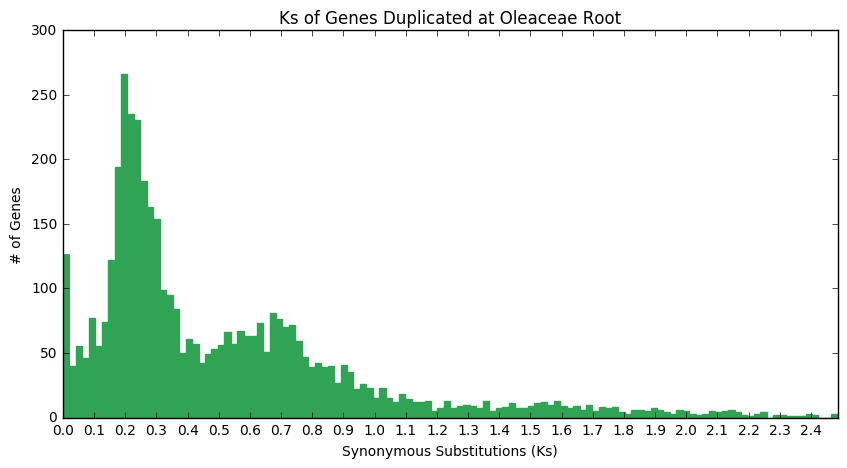

In [28]:
Ks_cap = converted_liz['Ks'] < 2.5
filtered_Ks = converted_liz[filtered_rows & Ks_cap]['Ks']
# pretty_hist("Ks of Genes Duplicated at Oleaceae Root", filtered_Ks, 
#             x_title="Synonymous Substitutions (Ks)", y_title="Number of Genes", bins = 120)

plt.xticks(np.arange(0, 2.6, .1))
h = filtered_Ks.hist(bins=120, figsize=(10,5), facecolor='#31a354', edgecolor='#31a354')
h.grid(False)
# h.linewidth(0)
h.set_xlabel("Synonymous Substitutions (Ks)")
h.set_ylabel('# of Genes')
h.set_title("Ks of Genes Duplicated at Oleaceae Root")

**Conclusion** That looks the exact same as the population distribution.  Rooted copy number filtering was unsuccessful.  I need to switch datasets to a more recent simulations.  Homeologs may be necessary to make sure "gene family" doesn't diffuse the results too much.

In [35]:
%%html
<img src="CAFE-4.2/data/Ks values of F excelsior paralogs.png">

# Gene Tree Accounting with Duplications.csv

In [1]:
from collections import defaultdict
N1_counts = defaultdict(lambda: 0)
from csv import DictReader

with open("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv",'r') as infile:
    lines = DictReader(infile, delimiter='\t')
    print(lines.fieldnames)
    for line in lines:
        if line['Species Tree Node'] == 'N1':  # count mentions of N1
            N1_counts[line['Orthogroup']] += 1

['Orthogroup', 'Species Tree Node', 'Gene Tree Node', 'Support', 'Type', 'Genes 1', 'Genes 2']


In [2]:
heights = []
for i in range(1, 10):
    heights.append(len([og for og, c in N1_counts.items() if c == i]))
    print(i,       len([og for og, c in N1_counts.items() if c == i]))
print('All', len(N1_counts))

1 4242
2 2377
3 1256
4 680
5 350
6 194
7 125
8 85
9 57
All 9546


In [6]:
pp((4242+2377+1256+680)/9546)

'89.618688%'

In [7]:
from math import log
log(10) / log(2)

3.3219280948873626

<Container object of 9 artists>

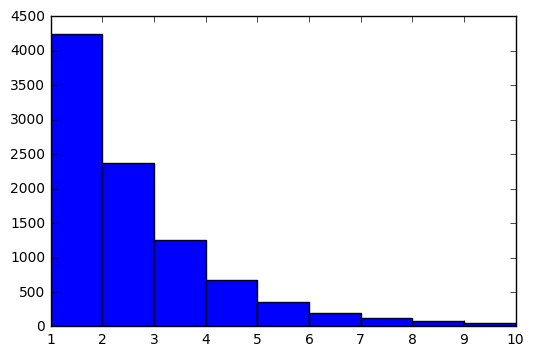

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.bar([1,2,3,4,5,6,7,8,9], heights, width=1)

<Container object of 9 artists>

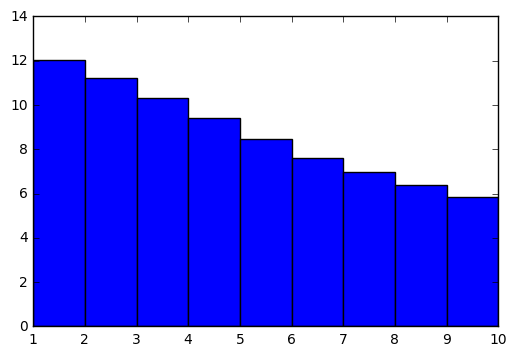

In [9]:
fig, ax = plt.subplots()
ax.bar([1,2,3,4,5,6,7,8,9], [log(h)/log(2) for h in heights], width=1)

In [10]:
for i, h in enumerate(heights):
    if i:
        print(round(heights[i-1] / h, 2))

1.78
1.89
1.85
1.94
1.8
1.55
1.47
1.49


**Conclusion** That is eerily close to a perfectly straight line on the log scale.  The chance of seeing N+1 duplication events is a percentage of the previous number.

In [11]:
internal_mentions = defaultdict(lambda: 0)
with open("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv",'r') as infile:
    lines = DictReader(infile, delimiter='\t')
    for line in lines:
        if line['Species Tree Node'].startswith('N'):  # count mentions of anything not a species
            internal_mentions[line['Orthogroup']] += 1

len(internal_mentions)

16371

In [12]:
OG_names = set()
with open("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv",'r') as infile:
    lines = DictReader(infile, delimiter='\t')
    for line in lines:
        OG_names.add(line['Orthogroup'])
len(OG_names)

19118

**Conclusion** 85% of OGs with a duplication have an internal duplication.  49.9% of them mention N1.  22% have one duplication there, 2377+4242 = 34% of them have 1 or 2 duplications at N1.  There's still twice as many with 1 than 2.  I would need Jasmine to separate the two categories.  

# Separate out Study Homeologs into pairs of trees

In [15]:
study_homeologs = [og for og, c in N1_counts.items() if c == 1]
len(study_homeologs), study_homeologs[:5]

(4242, ['OG0014632', 'OG0004853', 'OG0009334', 'OG0010848', 'OG0001764'])

In [19]:
rows = read_csv("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv", delimiter='\t')

In [30]:
print(sum(rows['Species Tree Node'] == 'N1'))
rows[rows['Orthogroup'].isin(study_homeologs[:10]) & (rows['Species Tree Node'] == 'N1')]

22943


,Orthogroup,Species Tree Node,Gene Tree Node,Support,Type,Genes 1,Genes 2
31103,OG0001764,N1,n63,0.032258,Shared,Oeuropea_OE6A044264P2,"FRAX16_FRAX16_000371250.1_R0, FRAX01_FRAX01_00..."
43210,OG0003222,N1,n2,0.709677,Shared,"Oeuropea_OE6A100108P2, FRAX08_FRAX08_000281330...","FRAX09_FRAX09_000383080.1_R0, FRAX03_FRAX03_00..."
50420,OG0004227,N1,n2,1.000000,Shared,"FRAX34_FRAX34_000332170.1_R0, FRAX33_FRAX33_00...","Oeuropea_OE6A098656P1, FRAX31_FRAX31_000294490..."
53763,OG0004853,N1,n1,0.967742,Shared,"FRAX29_FRAX29_000072950.2_R0, FRAX08_FRAX08_00...","FRAX02_FRAX02_000072950.1_R0, FRAX00_FRAEX3887..."
60714,OG0006573,N1,n2,0.838710,Shared,"FRAX31_FRAX31_000064730.1_R1, FRAX21_FRAX21_00...","FRAX13_FRAX13_000284330.1_R0, FRAX05_FRAX05_00..."
69067,OG0008631,N1,n2,0.645161,Shared,"FRAX25_FRAX25_000204080.1_R0, FRAX29_FRAX29_00...","Oeuropea_OE6A010090P1, FRAX14_FRAX14_000219010..."
72086,OG0009334,N1,n2,0.516129,Shared,"FRAX14_FRAX14_000156740.1_R1, FRAX34_FRAX34_00...","Oeuropea_OE6A062116P1, Oeuropea_OE6A017651P1, ..."
78591,OG0010848,N1,n2,0.258065,Shared,"FRAX00_FRAEX38873_v2_000328180.1, FRAX16_FRAX1...","Oeuropea_OE6A092972P2, FRAX33_FRAX33_000343560..."
87689,OG0014632,N1,n15,0.032258,Shared,Oeuropea_OE6A055992P1,"FRAX32_FRAX32_000262350.1_R0, FRAX30_FRAX30_00..."
90145,OG0017034,N1,n0,0.225806,Shared,"FRAX21_FRAX21_000383580.1_R1, FRAX16_FRAX16_00...","FRAX15_FRAX15_000383580.1_R0, FRAX01_FRAX01_00..."


In [79]:
sample = ['OG0000212']#['OG0000013', 'OG0000057', 'OG0000069', 'OG0000138', 'OG0000193', 'OG0000212',]
(rows[(rows['Orthogroup'].isin(sample)) & (rows['Species Tree Node'] == 'N1')])#['Genes 1'])

,Orthogroup,Species Tree Node,Gene Tree Node,Support,Type,Genes 1,Genes 2
9512,OG0000212,N1,n102,0.16129,Shared,"Oeuropea_OE6A042692P1, FRAX09_FRAX09_000167460...","FRAX31_FRAX31_000167460.1_R1, FRAX19_FRAX19_00..."


In [86]:
len(rows.loc[9512]['Genes 1'].split(', '))

56

*Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Recon_Gene_Trees\212_count_scrap.tre*  
A vs B subtrees after a duplication are defined in the "Genes 1" and "Genes 2" columns of Duplications.csv. The "Gene Tree Node" seems nonsensical, but the number and names of listed genes correspond to actual subtrees.

In [55]:
super_simple = [og for og in study_homeologs if sum(rows['Orthogroup']==og) == 1]
len(super_simple)

904

In [45]:
from shutil import copy
import os
from os.path import splitext, basename
os.chdir(r'D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul04_2')

## Rename every text file to a .tre file
from glob import glob
for f in glob('Gene_Trees/*.txt'):
    os.rename(f, 'Gene_trees/'+splitext(basename(f))[0]+'.tre')
    
for f in glob('Recon_Gene_Trees/*.txt'):
    os.rename(f, 'Recon_Gene_trees/'+splitext(basename(f))[0]+'.tre')

## Splitting into pairs of sets of genes following the WGD

In [105]:
#This code can run independently of the rest of the notebook
from collections import defaultdict
from pandas import read_csv
N1_counts = defaultdict(lambda: 0)
os.chdir(r'D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications')
rows = read_csv("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv", delimiter='\t')
for index, line in rows[rows['Species Tree Node'] == 'N1'].iterrows():
    og = line['Orthogroup']
    N1_counts[og] += 1
study_homeologs = [og for og, c in N1_counts.items() if c == 1]

In [107]:
print(len(study_homeologs))
study_rows = rows[rows['Orthogroup'].isin(study_homeologs) & (rows['Species Tree Node'] == 'N1')]
len(study_rows)

4242


4242

In [108]:
split_families = {}  # could be output as files
for index, row in study_rows.iterrows():
    og = row['Orthogroup']
    split_families[og + '_1'] = row['Genes 1'].split(', ')
    split_families[og + '_2'] = row['Genes 2'].split(', ')
len(split_families)

8484

In [114]:
print(pp(sum([len(v) for v in split_families.values()])), "Total Genes included in the study, separated over", pp(len(split_families)), "gene families")

207,864 Total Genes included in the study, separated over 8,484 gene families


### *Todo: Convert split_families to a square table of gene counts per species*

In [115]:
len(split_families)

8484

Peel off first part of gene name for species count

In [120]:
gene_set = set()
gene_set.update(*(v for v in split_families.values()))
len(gene_set)

207864

In [121]:
unique_starts = set()
for gene in gene_set:
    unique_starts.add(gene.split('_')[0])
unique_starts

{'FRAX00',
 'FRAX01',
 'FRAX02',
 'FRAX03',
 'FRAX04',
 'FRAX05',
 'FRAX06',
 'FRAX07',
 'FRAX08',
 'FRAX09',
 'FRAX11',
 'FRAX12',
 'FRAX13',
 'FRAX14',
 'FRAX15',
 'FRAX16',
 'FRAX19',
 'FRAX20',
 'FRAX21',
 'FRAX23',
 'FRAX25',
 'FRAX26',
 'FRAX27',
 'FRAX28',
 'FRAX29',
 'FRAX30',
 'FRAX31',
 'FRAX32',
 'FRAX33',
 'FRAX34',
 'Oeuropea'}

In [122]:
[gene for gene in gene_set if not gene.startswith('FRAX') and not gene.startswith('Oeuropea')]

[]

**Conclusion:** There are no Solanum or Erythranthe genes in these subtrees.  That was probably an implicit criteria of their selection.  Is this a problem?  Since I'm retaining the original OG names, we can always cross reference the included subtrees and the excluded subtrees (which would contain Solanum and Erythranthe).

*TODO: Pull OG out of Orthogroups.csv and remove the genes listed in "Genes 1" and "Genes 2" (also in gene_set) and save this as OG#####_out.*

In [143]:
def species_count_from_subtree(subtree):
    assert hasattr(subtree, '__iter__')
    sub_counts = defaultdict(lambda: 0)
    for gene in subtree:
        sub_counts[gene.split('_')[0]] += 1
    assert sum(sub_counts.values()) == len(subtree)
    return sub_counts
species_count_from_subtree(split_families['OG0000212_1'])

defaultdict(<function __main__.species_count_from_subtree.<locals>.<lambda>>,
            {'FRAX00': 2,
             'FRAX01': 2,
             'FRAX02': 4,
             'FRAX03': 1,
             'FRAX04': 2,
             'FRAX06': 2,
             'FRAX07': 1,
             'FRAX08': 3,
             'FRAX09': 1,
             'FRAX11': 1,
             'FRAX12': 3,
             'FRAX13': 1,
             'FRAX14': 2,
             'FRAX15': 2,
             'FRAX16': 1,
             'FRAX19': 1,
             'FRAX20': 3,
             'FRAX21': 1,
             'FRAX23': 1,
             'FRAX25': 1,
             'FRAX26': 3,
             'FRAX27': 2,
             'FRAX28': 1,
             'FRAX29': 4,
             'FRAX30': 4,
             'FRAX31': 2,
             'FRAX32': 2,
             'FRAX33': 2,
             'Oeuropea': 1})

In [175]:
from pandas import DataFrame, Series
data = {}
for name, subfamily in split_families.items():
    sub_counts = species_count_from_subtree(subfamily)
    data[name] = sub_counts
df = DataFrame.from_dict(data, orient='index', )#columns=sorted(unique_starts) )

In [176]:
# Formatting the table
df.fillna(value=0, inplace=True)
df = df.astype(int)

df.index.name = 'Desc'
df['Family ID'] = df.apply(lambda row: str(row.name)[-1:] + str(row.name)[2:-2], axis=1) # e.g. OG0000212_1 => 10000212
column_order = ['Family ID'] + sorted(unique_starts)
df = df[column_order]
df.head()

,Family ID,FRAX00,FRAX01,FRAX02,FRAX03,FRAX04,FRAX05,FRAX06,FRAX07,FRAX08,...,FRAX26,FRAX27,FRAX28,FRAX29,FRAX30,FRAX31,FRAX32,FRAX33,FRAX34,Oeuropea
Desc,,,,,,,,,,,,,,,,,,,,,
OG0000013_1,10000013,1,1,0,1,1,1,2,2,1,...,0,1,1,2,2,1,1,2,1,1
OG0000013_2,20000013,3,3,1,1,1,2,2,1,1,...,2,1,1,1,1,2,1,1,1,0
OG0000057_1,10000057,1,1,0,0,0,0,1,0,1,...,1,1,0,1,0,0,1,1,0,1
OG0000057_2,20000057,2,11,16,8,8,10,6,9,8,...,6,9,12,10,10,1,11,6,12,0
OG0000069_1,10000069,2,6,7,9,8,9,6,10,8,...,8,9,9,8,11,9,8,9,6,1


In [177]:
df.to_csv(r'CAFE-4.2\data\homeologs_only\homeolog_counts.txt', sep='\t')